## isolated clustering including recombination of mini-cluster for hpc run 

Comments:

ClusterGCN baseline, KDD 2020

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pickle
import shutil

from utils import *


In [3]:
import inspect
import torch
from torch_geometric.utils import scatter_

import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)

    # change the dropout positions: 
    def forward(self, edge_index, features):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = F.relu(self.layers[i](features, edge_index))
#                 if i>0:
                features = F.dropout(features, p = self.dropout, training = self.training)
                    
            features = self.layers[len(self.layers)-1](features, edge_index)
        else:
            features = self.layers[0](features, edge_index)    # for a single layer case
        
        predictions = features
        # just use the linear layer output, since we are using the cross-entropy loss
        # just pay attention to the test part, change the predictions
        
#         predictions = F.log_softmax(features, dim=1)
        # if using the nll loss, then we need this log_softmax layer
        
        return predictions

### Partition GCN

In [4]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/', info_folder = './info/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = torch.tensor(label, dtype=torch.float)
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        self.info_folder = info_folder
        
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        
    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
        
    # 1) first use different clustering method, then split each cluster into train, test and validation nodes, split edges
    def split_cluster_nodes_edges(self, validation_ratio, test_ratio, mini_cluster_num = 4, train_batch_num = 2, round_num = 2):
        """
            1) decompose the whole graph into parition_num small mini-clusters, all the mini-cluster relevant use local variables
            2) recombine the mini-clusters into train_batch_num batches (self.sg_nodes_global)
            3) test is for the unseen data
            4) validation is for the cross-validation purpose
        """
        mini_cluster_nodes_global = self.metis_clustering(self.graph, mini_cluster_num)
        mini_cluster_id = list(mini_cluster_nodes_global.keys())
        
        relative_validation_ratio = (validation_ratio) / (1 - test_ratio)
        
        mini_cluster_test_nodes_global = {}
        mini_cluster_train_nodes_global = {}
        mini_cluster_validation_nodes_global = {}
        
        for cluster in mini_cluster_id:
            mini_cluster_model_nodes_global, mini_cluster_test_nodes_global[cluster] = \
                    train_test_split(mini_cluster_nodes_global[cluster], test_size = test_ratio)
            mini_cluster_train_nodes_global[cluster], mini_cluster_validation_nodes_global[cluster] = \
                    train_test_split(mini_cluster_model_nodes_global, test_size = relative_validation_ratio)
            
        #recombine_mini_cluster_for_batch:
        sg_test_nodes_global = {}
        self.sg_nodes_global = {}
        self.sg_train_nodes_global = {}
        self.sg_validation_nodes_global = {}
        # keep the info of each cluster:
        self.info_isolate_cluster_size = {}
        self.info_test_cluster_size = {}
        self.info_train_cluster_size = {}
        self.info_validation_cluster_size = {}
        # compute how many elements is inside each batch
        chunck_size = mini_cluster_num // train_batch_num
        for round_id in range(round_num):
            # first shuffle all the mini-cluster ids:
            mini_cluster_order = mini_cluster_id
            random.shuffle(mini_cluster_order)
            combine_group = [mini_cluster_order[i * chunck_size : (i + 1) * chunck_size] for i in range((len(mini_cluster_order) + chunck_size - 1) // chunck_size )]  
            for local_batch_id, group in enumerate(combine_group):
                global_batch_id = round_id * train_batch_num + local_batch_id
                self.sg_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_nodes_global[cluster_id] for cluster_id in group))
                sg_test_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_test_nodes_global[cluster_id] for cluster_id in group))
                self.sg_train_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_train_nodes_global[cluster_id] for cluster_id in group))
                self.sg_validation_nodes_global[global_batch_id] = list(chain.from_iterable(mini_cluster_validation_nodes_global[cluster_id] for cluster_id in group))
        
        # accumulate all the validation nodes for validation process:
        self.test_nodes_global = list(chain.from_iterable(sg_test_nodes_global.values()))
        
        for batch in self.sg_nodes_global.keys():
            # record the information of each recombined batch:
            self.info_isolate_cluster_size[batch] = len(self.sg_nodes_global[batch])
            self.info_train_cluster_size[batch] = len(self.sg_train_nodes_global[batch])
            self.info_validation_cluster_size[batch] = len(self.sg_validation_nodes_global[batch])
    
    
    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        # randomly divide into two clusters
        nodes_order = [node for node in target_nodes]
        random.shuffle(nodes_order)
        n = (len(nodes_order) + partition_num - 1) // partition_num
        partition_list = [nodes_order[i * n:(i + 1) * n] for i in range(partition_num)]
#         cluster_membership = {node : i for i, node_list in enumerate(partition_list) for node in node_list}
        cluster_nodes_global = {i : node_list for i, node_list in enumerate(partition_list)}
        
        return cluster_nodes_global

    def metis_clustering(self, target_graph, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        (st, parts) = metis.part_graph(target_graph, partition_num)
        clusters = list(set(parts))
        cluster_nodes_global = defaultdict(list)
        for node, cluster_id in enumerate(parts):
            cluster_nodes_global[cluster_id].append(node)
        return cluster_nodes_global

    # for use of validation on the whole graph as a whole in CPU-side memory
    def whole_batch_generate(self, batch_file_folder, test_nodes):
        """
            For use of testing the model: generate the needed tensors for testing in CPU-memory side
        """
        # store the global edges
        whole_nodes_global = sorted(self.graph.nodes())
        whole_edges_global = {edge for edge in self.graph.edges()}
        
        whole_edges_local = \
                       [ [ left, right ] for left, right in whole_edges_global ] + \
                       [ [ right, left ] for left, right in whole_edges_global ] + \
                       [ [i, i] for i in whole_nodes_global ]  
        
        # store local features and lables
        whole_features_local = self.features
        whole_labels_local = self.label

        # transform all the data to the tensor form
        whole_edges_local = torch.LongTensor(whole_edges_local).t()
        whole_features_local = torch.FloatTensor(whole_features_local)
        whole_labels_local = torch.FloatTensor(whole_labels_local)
        whole_test_nodes_local = torch.LongTensor( sorted(test_nodes) )

        whole_batch_data = [whole_test_nodes_local, whole_edges_local, whole_features_local, whole_labels_local]

        batch_file_name = batch_file_folder + 'batch_whole'

        # store the batch files
        t0 = time.time()
        with open(batch_file_name, "wb") as fp:
            pickle.dump(whole_batch_data, fp)
        store_time = ((time.time() - t0) * 1000)
        print('*** Generate batch file for # {0} batch, writing the batch file costed {1:.2f} ms ***'.format("whole graph", store_time) )
    
    
    
    def mini_batch_generate(self, batch_file_folder, train_seed, validation_seed, batch_range = (0, 1)):
        """
            create the mini-batch focused on the train nodes only, include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
            fraction: fraction of neighbor nodes in each layer to be considered
            Input:
                1) train_seed: global ids of the nodes for seed to generate the train batch
                2) validation_seed: global ids of the nodes for seed to generate the validation batch, to investigate convergence during training
            Output: all tensors which are gonna be used in the train, forward procedure
                local:
                    1) sg_mini_edges_local
                    2) self.sg_mini_train_edge_weight_local
                    3) self.sg_mini_train_nodes_local
                    4) self.sg_mini_train_features
                    5) self.sg_mini_train_labels
            
        """
        info_batch_node_size = {}
        info_batch_edge_size = {}
        batch_start, batch_end = batch_range
        for cluster in range(batch_start, batch_end):
            batch_subgraph = self.graph.subgraph(self.sg_nodes_global[cluster])
            
             # first generate all the global ids for all nodes in one isolate batch
            mini_nodes_global = sorted(node for node in batch_subgraph.nodes())
            
            # store the global edges
            mini_edges_global = {edge for edge in batch_subgraph.edges()}
            
            # map nodes from global index to local index
            mini_mapper = {node: i for i, node in enumerate(mini_nodes_global)}
            
            # store local index of batch nodes
            mini_train_nodes_local = [ mini_mapper[global_idx] for global_idx in train_seed[cluster] ]
            
            # store local index of batch nodes
            mini_validation_nodes_local = [ mini_mapper[global_idx] for global_idx in validation_seed[cluster] ]
            
            # store local index of batch edges
            mini_edges_local = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in mini_edges_global ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in mini_edges_global ]
            
            # store local features and lables
            mini_features = self.features[mini_nodes_global,:]
            mini_labels = self.label[mini_nodes_global]
            
            # record information 
            info_batch_node_size[cluster] = len(mini_nodes_global)
            info_batch_edge_size[cluster] = len(mini_edges_local)
            
            # transfer to the tensor type
            mini_edges_local = torch.LongTensor(mini_edges_local).t()
            mini_features = torch.FloatTensor(mini_features)
            mini_labels = torch.FloatTensor(mini_labels)
            mini_train_nodes_local = torch.LongTensor(mini_train_nodes_local)
            mini_validation_nodes_local = torch.LongTensor(mini_validation_nodes_local)
            
            minibatch_data = [mini_edges_local, mini_features, mini_labels, mini_train_nodes_local, mini_validation_nodes_local]
            
            batch_file_name = batch_file_folder + 'batch_' + str(cluster)
            
            # store the batch files
            t0 = time.time()
            with open(batch_file_name, "wb") as fp:
                pickle.dump(minibatch_data, fp)
            store_time = ((time.time() - t0) * 1000)
            print('*** Generate batch file for # {0:3d} batch, writing the batch file costed {1:.2f} ms ***'.format(cluster, store_time) )
#             print('writing to the path: ', batch_file_name)
            
        return info_batch_node_size, info_batch_edge_size
    
    def save_info_dict(self, data, file_name, target_folder, header = 'key, value'):
        # output the batch size information as the csv file
#         os.makedirs(os.path.dirname(target_folder), exist_ok=True)
        target_file = target_folder + file_name
        
        with open(target_file, 'a', newline='\n') as fp:
            wr = csv.writer(fp, delimiter = ',')
            fp.write('\n')
            wr.writerow(header.split(','))
            for key, val in data.items():
                wr.writerow([key+1, val])
    
    def mini_batch_train_clustering(self, batch_folder, batch_range = (0, 1), info_folder = './info/', info_file = 'train_batch_size_info.csv'):
        data_type = 'train'
        batch_file_folder = batch_folder + data_type + '/'
        check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_train_batch_node_size, self.info_train_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_train_nodes_global, self.sg_validation_nodes_global, batch_range = batch_range)
        self.info_train_seed_size = {key : len(val) for key, val in self.sg_train_nodes_global.items()}
        
        self.save_info_dict(self.info_train_batch_node_size, info_file, info_folder, header = 'train_batch_node_id, train_batch_node_size')
        self.save_info_dict(self.info_train_batch_edge_size, info_file, info_folder, header = 'train_batch_edge_id, train_batch_edge_size')
        self.save_info_dict(self.info_train_seed_size, info_file, info_folder, header = 'train_seed_node_id, train_seed_node_size')
        
    def whole_test_clustering(self, batch_folder, info_folder = './info/', info_file = 'test_whole_size_info.csv'):
        data_type = 'test'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.whole_batch_generate(batch_file_folder, self.test_nodes_global)        
        


#### Partition Graph with trainiing and testing

In [5]:
# from Custom_GCN_layer import Net
import time
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from collections import defaultdict

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, data_folder, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.test_device = torch.device("cpu")
        
        self.data_folder = data_folder
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, tr_train_nodes, tr_edges, tr_features, tr_target):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(tr_edges, tr_features)
        
        _loss = torch.nn.BCEWithLogitsLoss()
        ave_loss = _loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
#         ave_loss = torch.nn.functional.cross_entropy(predictions[tr_train_nodes], tr_target[tr_train_nodes])
        node_count = tr_train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count

    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item() * node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss
    
    def train_investigate_F1(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, output_period = 10, train_batch_num = 2):
        """
            *** Periodically output the F1 score during training. After certain number of epochs ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
            output_period:  number of epochs after which output the F1 and accuray to investigate the model refining process
        """
        investigate_f1 = {}
        investigate_accuracy = {}
        investigate_targets = defaultdict(list)
        investigate_predictions = defaultdict(list)
        
        # start the training investigation
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   #   set into train mode, only effective for certain modules such as dropout and batchNorm
        self.record_ave_training_loss = []
        
        self.time_train_load_data = 0
        total_data_IO_time = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch_part in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                total_data_IO_time += (time.time() - t2) * 1000
                
                tr_edges, tr_features, tr_target, tr_train_nodes, tr_validation_nodes = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_validation_nodes = tr_validation_nodes.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.node_count_seen = 0
                    self.accumulated_training_loss = 0

                    # record the current overall epoch index:
                    real_epoch_num = 1 + mini_epoch + mini_epoch_num * epoch_part # real_epoch_num starts from 0, therefore we add 1

                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    self.record_ave_training_loss.append(ave_loss)

                    # at this point finish a single train duration: update the parameter and calcualte the loss function
                    # periodically output the F1-score in the middle of the training process
                    if real_epoch_num % output_period == 0:
                        targets, predictions = self.middle_check_batch_GPU_validation(tr_edges, tr_features, tr_target, tr_validation_nodes)
                        investigate_targets[real_epoch_num].append(targets)
                        investigate_predictions[real_epoch_num].append(predictions)
                        
        # convert to ms
        print('*** During training, reading all batch file I/O costed {0:.2f} ms ***'.format(total_data_IO_time) )
        self.time_train_total = ((time.time() - t0) * 1000) - total_data_IO_time
        
        for real_epoch_num in investigate_targets.keys():
            total_targets = np.concatenate(investigate_targets[real_epoch_num], axis = 0)
            total_predictions = np.concatenate(investigate_predictions[real_epoch_num], axis = 0)
            
            investigate_f1[real_epoch_num] = f1_score(total_targets, total_predictions, average="micro")
            investigate_accuracy[real_epoch_num] = binary_acc(total_targets, total_predictions)
        
        return investigate_f1, investigate_accuracy
    
    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, train_batch_num = 2):
        """
            *** Training a model. ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        # record the data uploading to GPU time, and the data IO time for each train batch
        self.time_train_load_data = 0
        total_data_IO_time = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                total_data_IO_time += (time.time() - t2) * 1000
                
                tr_edges, tr_features, tr_target, tr_train_nodes, _ = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.node_count_seen = 0
                    self.accumulated_training_loss = 0
                    
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    # record training loss per epoch
                    self.record_ave_training_loss.append(ave_loss)
            
        # convert to ms
        print('*** During training, total IO data reading time for all batches costed {0:.2f} ms ***'.format(total_data_IO_time) )
        self.time_train_total = ((time.time() - t0) * 1000) - total_data_IO_time
    
    
    def whole_cpu_test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.test_device = torch.device("cpu")
        test_model = self.model.to(self.test_device)
        test_model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        batch_file_name = self.data_folder + 'test/batch_whole'

        t2 = time.time()
        with open(batch_file_name, "rb") as fp:
            minibatch_data_test = pickle.load(fp)
        read_time = (time.time() - t2) * 1000
        print('*** During test for # {0} batch, reading batch file costed {1:.2f} ms ***'.format("whole graph", read_time) )

        test_nodes, test_edges, test_features, test_target = minibatch_data_test

        # select the testing nodes predictions and real labels
        y_pred = test_model(test_edges, test_features)[test_nodes]
        # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
        y_pred_tag = (torch.sigmoid(y_pred)).round()
        predictions = y_pred_tag.cpu().detach().numpy()
        
        targets = test_target[test_nodes].cpu().detach().numpy()
        
        f1 = f1_score(targets, predictions, average="micro")
#       accuracy = accuracy_score(targets.flatten(), predictions.flatten())   # for multi-class task, here have to be flatten first
        accuracy = binary_acc(targets, predictions)    # for multi-label task
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)
    
    
    def middle_check_batch_GPU_validation(self, validation_edges, validation_features, validation_target, validation_nodes):
        """
            Scoring the validation set and printing the F-1 score.
        """
        self.model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        # select the testing nodes predictions and real labels
        y_pred = self.model(validation_edges, validation_features)[validation_nodes]
        # for multi-label task, first use the sigmoid function and rounding to 0, 1.0 labels
        y_pred_tag = (torch.sigmoid(y_pred)).round()
        predictions = y_pred_tag.cpu().detach().numpy()
        
        targets = validation_target[validation_nodes].cpu().detach().numpy()
        
        self.model.train()
        return targets, predictions

### Use Trivial data

In [6]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([[0, 1], [1, 0], [1, 1], [1, 0], [0, 0], [0, 1], [1, 0], [1, 1], [1, 0], [0, 0]], dtype = torch.float)
print(features, features.shape)

# set the tmp folder
# tmp_folder = './tmp/'
# check_folder_exist(tmp_folder)
# os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
# set the store clustering path
tmp_folder = './res_save_batch/tmp/'
check_folder_exist(tmp_folder)
clustering_file_name = tmp_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
info_folder = './res_save_batch/info/'
check_folder_exist(info_folder)
os.makedirs(os.path.dirname(info_folder), exist_ok=True)


node_count = features.shape[0]
clustering_machine = ClusteringMachine(edge_index, features, label)
clustering_machine.split_cluster_nodes_edges(0.4, 0.4, mini_cluster_num = 2)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after split: ')

with open(clustering_file_name, "wb") as fp:
    pickle.dump(clustering_machine, fp)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### minibatch train nodes and batch validatioin 

In [7]:

mini_batch_folder = './res_save_batch/mini_batch_files/'
check_folder_exist(mini_batch_folder)

with open(clustering_file_name, "rb") as fp:
    clustering_machine = pickle.load(fp)

# generate the batches for train and validation
clustering_machine.mini_batch_train_clustering(mini_batch_folder, batch_range = (0, 2), info_folder = info_folder) # include number of layers
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after train clustering: ')

clustering_machine.whole_test_clustering(mini_batch_folder, info_folder = info_folder)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after validation clustering:  ')

# construct the batch trainer
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, input_layers = [16], dropout=0.3)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after generating trainer:  ')

gcn_trainer_batch.train(1, 0.0001, 0.1, train_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after training the batch:  ')

# gcn_trainer_batch.batch_validate(valid_batch_num = 2)

gcn_trainer_batch.whole_cpu_test()

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after validating the batch:  ')

*** Generate batch file for #   0 batch, writing the batch file costed 0.40 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.36 ms ***
*** Generate batch file for # whole graph batch, writing the batch file costed 0.31 ms ***
*** During training, total IO data reading time for all batches costed 0.63 ms ***
*** During test for # whole graph batch, reading batch file costed 0.24 ms ***


### basic execution

In [8]:
''' Execute the testing program '''
def set_clustering_machine(data, dataset, intermediate_data_folder, validation_ratio = 0.05, test_ratio = 0.85, train_batch_num = 2, mini_cluster_num = 16, round_num = 2):
    """
        Set the batch machine plus generate the training batches
            1) data: the target dataset data
            2) intermediate_data_folder: path to store the intermediate generated data
            3) test_ratio, validation_ratio: data split ratio
            4) neigh_layer: number of hops (layers) for the neighbor nodes 
            5) train_frac: each time including fraction of the neigbor nodes in each layer
            6) valid_part_num, train_batch_num, test_part_num :  batch number for validation, train and test data correspondingly
    """
    # set the tmp file for garbage tmp files, just collect the info:
    tmp_folder = intermediate_data_folder + 'tmp/'
    check_folder_exist(tmp_folder)
    os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
    
    # Set the clustering information storing path
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    check_folder_exist(clustering_file_folder)  # if exist then delete
    check_folder_exist(data_info_file_folder)  # if exist then delete
    
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    data_info_file_name = data_info_file_folder + 'data_info_file.txt'
    os.makedirs(os.path.dirname(clustering_file_folder), exist_ok=True)
    os.makedirs(os.path.dirname(data_info_file_folder), exist_ok=True)
    

    print('\n' + '=' * 100)
    print('Start to generate the clustering machine:')
    t0 = time.time()
    # if we use the random assignment of the code, then filtering out the isolated data may not be necessary
    connect_edge_index, connect_features, connect_label = filter_out_isolate_normalize_feature(data.edge_index, data.x, data.y)
    clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label, tmp_folder)
    
#     clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder)
    batch_machine_create = time.time() - t0
    print('Batch machine creation costs a total of {0:.4f} seconds!'.format(batch_machine_create))
    
    node_count = connect_features.shape[0]
    feature_count = connect_features.shape[1]    # features all always in the columns
    edge_count = connect_edge_index.shape[1]
    print('\nEdge number: ', edge_count, '\nNode number: ', node_count, '\nFeature number: ', feature_count) 
    
    # at last output the information inside the folder:
    print_dir_content_info(tmp_folder)
    
    # mini-batch only: split to train test valid before clustering
    print('Start to split data into train, test, validation:')
    t1 = time.time()
    clustering_machine.split_cluster_nodes_edges(validation_ratio, test_ratio, mini_cluster_num = mini_cluster_num, train_batch_num = train_batch_num, round_num = round_num)
    data_split_time = time.time() - t1
    print('Data splitting costs a total of {0:.4f} seconds!'.format(data_split_time))
    
    print('Start to store the batch machine file:')
    t3 = time.time()
    with open(clustering_file_name, "wb") as fp:
        pickle.dump(clustering_machine, fp)
    
    # data number we requred are the feature number and the classes, note after the filtering, the node number may be smaller by removing isolated nodes
    data_info = (dataset.num_node_features, dataset.num_classes )
    with open(data_info_file_name, "wb") as fp:
        pickle.dump(data_info, fp)

    batch_machine_store_time = time.time() - t3
    print('Storing batch machine after training batches generation costs a total of {0:.4f} seconds!'.format(batch_machine_store_time))
    print('\n' + '=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', info_GPU_memory_folder, comment ='after setting clustering machine: ')
    
def set_clustering_machine_train_batch(intermediate_data_folder, \
                                      batch_range = (0, 1), info_folder = 'info_train_batch/', info_file = 'train_batch_size_info.csv'):
    """
        Generate the train batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
#     check_folder_exist(intermediate_data_folder)  # if exist then delete
    print('Start to generate the training batches:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t2 = time.time()
    clustering_machine.mini_batch_train_clustering(intermediate_data_folder, \
                                                   batch_range = batch_range, info_folder = info_folder, info_file = info_file)
    train_batch_production_time = time.time() - t2
    print('Train batches production costs a total of {0:.4f} seconds!'.format(train_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'train/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_cost_setting_train_batch.txt', info_GPU_memory_folder, comment ='after generating train batches: ')

def set_clustering_machine_test_whole_graph(intermediate_data_folder, \
                                                  info_folder = 'info_test_whole_graph/', info_file = 'test_whole_graph_size_info.csv'):
    """
        Generate the test batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    print('Start to generate the test whole graph:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t1 = time.time()
    # create the test batch for the whole graph
    clustering_machine.whole_test_clustering(intermediate_data_folder, info_folder = info_folder)
    
    test_batch_production_time = time.time() - t1
    print('Test batches production costs a total of {0:.4f} seconds!'.format(test_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'test/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_memory_cost_generate_test_data.txt', info_GPU_memory_folder, comment ='after generating test for whole graph: ')

def Cluster_train_batch_run(trainer_id, intermediate_data_folder, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_batch_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
        
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_batch_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    
    print('Start to save the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t2 = time.time()
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)
    store_trainer = time.time() - t2
    print('Storing the trainer costs a total of {0:.4f} seconds!'.format(store_trainer))
    print('-' * 80)
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_batch_train.txt', info_GPU_memory_folder, comment ='after generating trainer and train minibatches: ')


def Cluster_valid_batch_run(trainer_id, intermediate_data_folder):
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    
    print('Start validate the model:')
    t2 = time.time()
#     test_F1, test_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    test_F1, test_accuracy = gcn_trainer.whole_cpu_test()
    test_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(test_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_run_cpu_test.txt', info_GPU_memory_folder, comment ='after validating minibatches: ')
    
    return test_accuracy, test_F1, time_train_total, time_data_load


def Cluster_tune_train_run(intermediate_data_folder, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_batch_num = 2):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: test accuracy value, test F-1 value, time_training (ms), time_data_load (ms)
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_batch_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('-' * 80)
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_tune_batch_train.txt', info_GPU_memory_folder, comment ='after tune training: ')
    
    return gcn_trainer
    
    
def Cluster_tune_test_run(gcn_trainer, intermediate_data_folder):
    
    print('Start validate the model:')
    t2 = time.time()
    test_F1, test_accuracy = gcn_trainer.whole_cpu_test()
    
    test_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(test_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_tune_whole_test.txt', info_GPU_memory_folder, comment ='after test whole graph: ')
    return test_accuracy, test_F1, time_train_total, time_data_load


def Cluster_train_valid_batch_investigate(intermediate_data_folder, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, output_period = 10, 
                                         train_part_num = 2):
    """
        *** dynamically investigate the F1 score in the middle of the training after certain period ***
        output: two dict containing F1-score and accuracy of a certain epoch index
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    Train_period_F1, Train_period_accuracy = gcn_trainer.train_investigate_F1(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, \
                                                            output_period = output_period, train_batch_num = train_part_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('-' * 80)
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_train_batch_investigate.txt', info_GPU_memory_folder, comment ='after train batch investigate: ')
    
    return Train_period_F1, Train_period_accuracy

### Test and compare different models

In [9]:
def execute_one_train(mini_batch_folder, trainer_id = 0, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                train_batch_num = 2):
    """
        Perform one train for one time, store the corresponding trainer for future testing
    """
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
#     check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    Cluster_train_batch_run(trainer_id, mini_batch_folder, input_layer = input_layer, epochs=epoch_num, \
                             dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                             train_batch_num = train_batch_num)
    
def execute_one_test(mini_batch_folder, trainer_list = [0]):
    """
        return all test-F1 and test-F1 for all four models
    """
    test_accuracy = {}
    test_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    # Each graph model corresponds to one function below
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    graph_model = ['batch_valid']
    for trainer_id in trainer_list:
        model_res = []
        model_res.append(Cluster_valid_batch_run(trainer_id, mini_batch_folder))
        
        test_accuracy[trainer_id], test_f1[trainer_id], time_total_train[trainer_id], time_data_load[trainer_id] = zip(*model_res)
    return graph_model, test_accuracy, test_f1, time_total_train, time_data_load

def store_data_multi_tests(f1_data, data_name, graph_model, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id}
    
    run_data.update({model_name : [f1_data[key][idx] for key in run_id] for idx, model_name in enumerate(graph_model)})
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    
    

### Tune hyperparameters

In [10]:
#  To test one single model for different parameter values 
def execute_tuning_train(mini_batch_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, input_layer = [32], epoch_num = 400, \
                  dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                  train_batch_num = 2):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    Trainer_folder = mini_batch_folder + 'GCN_tuning/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
#     check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
    
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    gcn_trainer = Cluster_tune_train_run(mini_batch_folder, input_layer = input_layer, epochs=epoch_num, \
                    dropout = dropout, lr = tune_val, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                    train_batch_num = train_batch_num)
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)

# this tuning test requires the image_path to store all the results as the picle file
def execute_tuning_test(image_path, mini_batch_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    
    Trainer_folder = mini_batch_folder + 'GCN_tuning/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    # res are: test_accuracy, test_F1, time_train_total, time_data_load
    res = Cluster_tune_test_run(gcn_trainer, mini_batch_folder)
    
    # store the resulting data on the disk
    test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump(res, fp)
        
    
def summarize_tuning_res(image_path, mini_batch_folder, tune_param_name, tune_val_label_list, tune_val_list, trainer_list):
    """
        tune_val_label_list :  label of the tuning parameter value for file location
        tune_val_list  :       the real value of the tuning parameter
    """
    test_accuracy = {}
    test_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = []
    for trainer_id in trainer_list:
        ref = {}
        for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
            test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
            test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
            with open(test_res_file, "rb") as fp:
                ref[tune_val] = pickle.load(fp)
        res.append(ref)
    
    for i, ref in enumerate(res):
        test_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        test_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return test_accuracy, test_f1, time_total_train, time_data_load


def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

###  Investigate the F1 score during training

In [11]:
### ======== Investigate F1-score on the fly
def execute_investigate(image_path, mini_batch_folder, tune_param_name, tune_val_label, tune_val, trainer_id = 0, input_layer = [32], epoch_num = 300, \
                        dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 20, output_period = 10, \
                         train_part_num = 2):
    """
        return all validation-F1 for all four models
    """
    Train_peroid_f1, Train_peroid_accuracy = Cluster_train_valid_batch_investigate(mini_batch_folder, input_layer = input_layer, epochs=epoch_num, \
                                        dropout = dropout, lr = tune_val, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                                                                train_part_num = train_part_num)
    
    # store the resulting data on the disk
    test_res_folder = image_path + 'tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump((Train_peroid_f1, Train_peroid_accuracy), fp)
        
def summarize_investigation_res(image_path, mini_batch_folder, trainer_list):
    Train_peroid_f1 = {}
    Train_peroid_accuracy = {}
    
    for trainer_id in trainer_list:
        ref = {}
        test_res_file = image_path + 'res_trainer_' + str(trainer_id)
        with open(test_res_file, "rb") as fp:
            Train_peroid_f1[trainer_id], Train_peroid_accuracy[trainer_id] = pickle.load(fp)
        
    return Train_peroid_f1, Train_peroid_accuracy
        
def store_data_multi_investigate(investigate_res, data_name, res_name, img_path, comments):
    """
        investigate_res: currently either F1-score or accuracy a dict {epoch num : value}
    """
    run_id = sorted(investigate_res.keys())
    run_data = {'run_id': run_id}
    
    epoch_num_range = sorted(investigate_res[0].keys())  # at least one entry exists inside the dictionary and the epoch range is fixed
    run_data.update({epoch_num : [investigate_res[key][epoch_num] for key in run_id] for epoch_num in epoch_num_range})
    
    pickle_filename = img_path + data_name + '_' + res_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Separate steps of HPC execution for one single task

In [12]:
def step0_generate_clustering_machine(data, dataset, intermediate_data_path, train_batch_num, \
                                      validation_ratio = 0.05, test_ratio = 0.85, mini_cluster_num = 16, round_num = 2):            
    print('Start running for train batch num: ' + str(train_batch_num) )

    # set the basic settings for the future batches generation
    set_clustering_machine(data, dataset, intermediate_data_path, validation_ratio = validation_ratio, test_ratio = test_ratio, \
                           train_batch_num = train_batch_num, mini_cluster_num = mini_cluster_num, round_num = round_num)

def step1_generate_train_batch(intermediate_data_path, batch_range = (0, 1), info_folder = 'info/'):            
    # set the save path
    print('Start running for train batch num: ' + str(batch_range) )
    info_file = 'train_batch_size_info_{}.csv'.format(str(batch_range))

    # generate the train batches
    set_clustering_machine_train_batch(intermediate_data_path, \
                                       batch_range = batch_range, info_folder = info_folder, info_file = info_file)

def step2_generate_test_whole_graph(intermediate_data_path, info_folder = 'info/'):            
    info_file = 'test_whole_graph_size_info.csv'
    # generate all the tensors from the  whole graph for test
    set_clustering_machine_test_whole_graph(intermediate_data_path, info_folder = info_folder, info_file = info_file)
            
def step3_run_train_batch(intermediate_data_path, train_batch_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400):            
    print('Start running training for train batch num: ' + str(train_batch_num))
    # start to train the model
    execute_one_train(intermediate_data_path, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, 
                                    dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                     train_batch_num = train_batch_num)
            

def step4_run_test_batch(image_data_path, intermediate_data_path, train_batch_num, net_layer_num, trainer_list = [0]):   
    """
        image_data_path:  path of to be stored result images
        intermediate_data_path :  path for all the intermediate results: clustering, train batches, trained trainers
        train_batch_num:  number of generated overlapping batches
        hop_layer:  number of to be included neighbor layers
        trainer_list :  list of all the trained trainer (gcn model instance) indices
    """
    # set the save path
    print('Start running test for train batch num: ' + str(train_batch_num) )
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'output_f1_score/'  # further subfolder for different task

    graph_model, test_accuracy, test_f1, time_total_train, time_data_load = \
        execute_one_test(intermediate_data_path, trainer_list = trainer_list)

    test_accuracy = store_data_multi_tests(test_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num))
    draw_data_multi_tests(test_accuracy, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Accuracy')

    test_f1 = store_data_multi_tests(test_f1, data_name, graph_model, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
    draw_data_multi_tests(test_f1, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'F1 score')

    time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
    draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Train Time (ms)')

    time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
    draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Load Time (ms)')




### Seperate steps for parameter tuning

In [13]:
def step30_run_tune_train_batch(intermediate_data_path, tune_param_name, tune_val_label, tune_val, train_batch_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400):            
    print('Start running training for partition num: ' + str(train_batch_num))
    # start to tune the model, run different training 
    execute_tuning_train(intermediate_data_path, tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, \
                                    dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                  train_batch_num = train_batch_num)
            
def step40_run_tune_test_whole(image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, \
                    trainer_id = 0): 
    # set the save path
    print('Start running training for partition num: ' + str(train_batch_num) )
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'tuning_parameters/'  # further subfolder for different task

    # start to validate the model, with different tuning parameters
    execute_tuning_test(img_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id)


### Separate steps for investigation training

In [14]:
def step31_run_investigation_train_batch(image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400, output_period = 40):            
    # start to tune the model, and investigate the performance in the middle
    print('Start running investigation training for train batch num: ' + str(train_batch_num) + '_trainer_id_' + str(trainer_id))
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'investigation_figures/'  # further subfolder for different task

    execute_investigate(img_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, \
                    dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                     train_part_num = train_batch_num)


### Postprocessing

In [15]:
def step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, \
                                    train_batch_num, net_layer_num, trainer_list): 
    
    print('Start running training for partition num: ' + str(train_batch_num))
    # set the batch for test and train
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'tuning_parameters/'  # further subfolder for different task

    # start to summarize the results into images for output

    test_accuracy, test_f1, time_total_train, time_data_load = summarize_tuning_res(img_path, intermediate_data_path, tune_param_name, tune_val_label_list, tune_val_list, trainer_list)

    generate_tuning_raw_data_table(test_accuracy, img_path, 'test_acc.csv', tune_param_name)
    test_accuracy_file = store_data_multi_tuning(tune_val_list, test_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_accuracy_file, data_name, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Accuracy')

    generate_tuning_raw_data_table(test_f1, img_path, 'test_f1.csv', tune_param_name)
    test_f1_file = store_data_multi_tuning(tune_val_list, test_f1, data_name, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(test_f1_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'F1 score')

    generate_tuning_raw_data_table(time_total_train, img_path, 'time_train_total.csv', tune_param_name)
    time_train_file = store_data_multi_tuning(tune_val_list, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_train_file, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Train Time (ms)')

    generate_tuning_raw_data_table(time_data_load, img_path, 'time_load_data.csv', tune_param_name)
    time_load_file = store_data_multi_tuning(tune_val_list, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
    draw_data_multi_tests(time_load_file, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Load Time (ms)')
 

def step41_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_label, tune_val, \
                                    train_batch_num, net_layer_num, trainer_list): 
    """
        Train investigation post-processing
        Train-validation at the same time
    """
    print('Start summarizing for train batch num: ' + str(train_batch_num) )
    # set the batch for validation and train
    img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
    img_path += 'investigation_figures/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    # start to summarize the results into images for output

    Train_peroid_f1, Train_peroid_accuracy = summarize_investigation_res(img_path, intermediate_data_path, trainer_list)

#     Train_peroid_f1_file = store_data_multi_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'invest_batch_num_' + str(train_batch_num))
#     draw_data_multi_tests(Train_peroid_f1_file, data_name, 'Train_process_batch_num_' + str(train_batch_num), 'epoch number', 'F1 score')

#     Train_peroid_accuracy_file = store_data_multi_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'invest_batch_num_' + str(train_batch_num) )
#     draw_data_multi_tests(Train_peroid_accuracy_file, data_name, 'Train_process_batch_num_' + str(train_batch_num), 'epoch number', 'Accuracy')
    
    
    Train_peroid_f1_file = store_data_each_trainer_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_f1_file, data_name, 'validation', 'epoch number', 'F1 score')
    
    Train_peroid_accuracy_file = store_data_each_trainer_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'validation')
    draw_data_validation_F1_trainer(Train_peroid_accuracy_file, data_name, 'validation', 'epoch number', 'Accuracy')


def check_train_loss_converge(image_path, mini_batch_folder, subfolder, data_name, trainer_id = 0):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + subfolder
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer_time = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer_time))
    
    # store the resulting data on the disk
    train_loss_path = image_path + 'trainer_loss/' + subfolder
    os.makedirs(os.path.dirname(train_loss_path), exist_ok=True)
    loss_res_file = train_loss_path + 'loss_trainer_' + str(trainer_id)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, gcn_trainer)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node(loss_res_file)

### Use dataset from GraphSaint

In [19]:
remote_data_root = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'
test_folder_name = 'clusterGCN/'

In [20]:
from GraphSaint_dataset import print_data_info, Flickr, Yelp, PPI_large, Amazon, Reddit, PPI_small
# suppose this is on the OSC cluster

data_name = 'PPI_small'
class_data = eval(data_name)
dataset = class_data(root = remote_data_root + data_name)
print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

intermediate_data_folder = './clusterGCN_multilabel_normalize/'
image_data_path = intermediate_data_folder + 'results/' + data_name + '/' + test_folder_name

# this is the parts we divide the graph
origin_train_batch_num = 8
round_num = 2
train_batch_num = round_num * origin_train_batch_num

GCN_layer = [128, 128]
net_layer_num = len(GCN_layer) + 1
# for non-optimization: hop_layer_num == net_layer_num
hop_layer_num = net_layer_num

tune_param_name = 'learning_rate'
tune_val_label_list = [2, 3, 4]
tune_val_list = [10**(-label) for label in tune_val_label_list]

trainer_list = list(range(2))


number of data 1
Info (attributes) of a single data instance
Data(edge_index=[2, 450540], test_mask=[14755], train_mask=[14755], val_mask=[14755], x=[14755, 50], y=[14755, 121]) 
 number of nodes:  14755 
 number of edges:  450540 
 number of features per ndoe:  50 
 number of edge features:  0 
 number of classifying labels of dataset:  121 
 all the attributes of data:  ['x', 'edge_index', 'y', 'train_mask', 'val_mask', 'test_mask']


### Output-F1

In [ ]:
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, origin_train_batch_num, validation_ratio = 0.12, test_ratio = 0.22, mini_cluster_num = 32, round_num = round_num)

step1_generate_train_batch(intermediate_data_folder, \
                           batch_range = (0, train_batch_num), 
                           info_folder = 'info_train_batch/' )

step2_generate_test_whole_graph(intermediate_data_folder, info_folder = 'info_test_whole/')

for trainer_id in trainer_list:
    step3_run_train_batch(intermediate_data_folder, train_batch_num, GCN_layer, \
                    trainer_id = trainer_id, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400)


step4_run_test_batch(image_data_path, intermediate_data_folder, train_batch_num, net_layer_num, trainer_list = trainer_list)



### Tune parameter

In [ ]:
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, origin_train_batch_num, validation_ratio = 0.12, test_ratio = 0.22, mini_cluster_num = 32, round_num = 2)

step1_generate_train_batch(intermediate_data_folder, \
                           batch_range = (0, train_batch_num), 
                           info_folder = 'info_train_batch/' )

step2_generate_test_whole_graph(intermediate_data_folder, info_folder = 'info_test_whole/')

# tuning the mini-epoch number
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step30_run_tune_train_batch(intermediate_data_folder, tune_param_name, tune_val_label, tune_val, train_batch_num, GCN_layer, \
                            trainer_id = trainer_id, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400)
            
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step40_run_tune_test_whole(image_data_path, intermediate_data_folder, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, \
                            trainer_id = trainer_id)
            
step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label_list, tune_val_list, \
                                train_batch_num, net_layer_num, trainer_list)

### Train investigate

Start running for train batch num: 8

Start to generate the clustering machine:
No isolated nodes number is found 
Label shape is: torch.Size([14755, 121])


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch machine creation costs a total of 2.2905 seconds!

Edge number:  450540 
Node number:  14755 
Feature number:  50

 Information about the content of ./clusterGCN_multilabel_normalize/tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 1.1014 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.1026 seconds!

Start running for train batch num: (0, 16)

Batch machine reading costs a total of 0.1247 seconds!
Start to generate the training batches:
*** Generate batch file for #   0 batch, writing the batch file costed 1.54 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 1.50 ms ***
*** Generate batch file for #   2 batch, writing the batch file costed 1.56 ms ***
*** Generate batch file for #   3 batch, writing the batch file costed 2.38 ms ***
*** Generate batch file for #   4 batch, writing the batch file costed 1.50 ms ***
*** Generate batch file 

/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/6_KDD_clusterGCN_hpc_version/utils.py:326: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through th

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

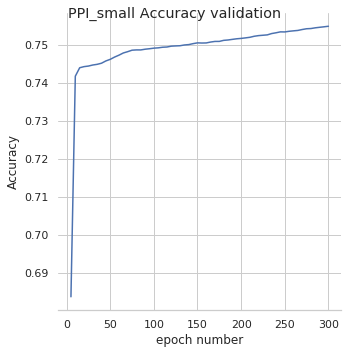

In [21]:
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, origin_train_batch_num, validation_ratio = 0.12, test_ratio = 0.22, mini_cluster_num = 32, round_num = 2)

step1_generate_train_batch(intermediate_data_folder, \
                           batch_range = (0, train_batch_num), 
                           info_folder = 'info_train_batch/' )

step2_generate_test_whole_graph(intermediate_data_folder, info_folder = 'info_test_whole/')

# train-batch investigate
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for tainer_id in trainer_list:
        step31_run_investigation_train_batch(image_data_path, intermediate_data_folder, tune_param_name, tune_val_label, tune_val, train_batch_num, net_layer_num, GCN_layer, \
                        trainer_id = tainer_id, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 1, epoch_num = 300, output_period = 5)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    step41_run_investigation_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_label, tune_val, \
                                    train_batch_num, net_layer_num, trainer_list)

### Output Training loss convergence


In [ ]:
# output for the train loss
subfolder = 'GCN_tuning/tune_batch_epoch_num_5/'
check_train_loss_converge(image_data_path, intermediate_data_folder, subfolder, data_name, trainer_id = 0)

In [ ]:
from GraphSaint_dataset import print_data_info, Flickr, Yelp, PPI_large, Amazon, Reddit
# suppose this is on the OSC cluster
remote_data_root = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'

data_name = 'Flickr'
dataset = Flickr(root = remote_data_root + data_name)
print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

In [ ]:
# another way to create class object from a string class name using eval():
data_name = 'Flickr'
data_class = eval(data_name)
print(data_class)
dataset = data_class(root = remote_data_root + data_name)
print('number of data', len(dataset))
data = dataset[0]
print_data_info(data, dataset)

In [ ]:
current_path = os.getcwd().split('/')
print(current_path)

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64]]

### CoraFull dataset

In [ ]:
from torch_geometric.datasets import CoraFull
data_name = 'CoraFull'
dataset = CoraFull(root = local_data_root + 'CoralFull')
print('number of data: ', len(dataset))
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './intermediate_data/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[128, 128]]
tune_lr = 0.0001
check_mini_epoch = 20

### CiteSeer Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [16], [16, 16]]

### Tuning the epoch number per batch

#### Checking train loss

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64], [64, 64, 64]]

#### Tune epoch number per batch

### Check the train error

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)
# torch.cuda.empty_cache()